In [1]:
import os, shutil
import numpy as np
from ROOT import TFile, TTree, TCanvas, TH1D, TH2D
from Scripts.DataFormat import Particle, Lepton, Jet, get_leptons, get_jets
from Plotter.PlotterTools.ObsAndExp import ObsAndExp
from ROOT import EnableImplicitMT
EnableImplicitMT(20)

Welcome to JupyROOT 6.22/08


In [2]:
# Global variables
sample_dir = "/root/workspace/HcToWA/Samples/Selector/2017/Skim1E2Mu__"
pd_list = ["DoubleMuon", "MuonEG"]
mc_list = ["rare", "conv", "ttX", "VV", "fake"]
prompts = mc_list.copy()
prompts.remove("fake")


In [3]:
# Get Fake Rate and Pileup
f_muon = TFile.Open("/root/workspace/HcToWA/MetaInfo/2017/fakerate_muon.root")
f_electron= TFile.Open("/root/workspace/HcToWA/MetaInfo/2017/fakerate_electron.root")
f_pileup = TFile.Open("/root/workspace/HcToWA/MetaInfo/2017/PUReweight_2017.root")
h_muon = f_muon.Get("h_fakerate")
h_electron = f_electron.Get("h_fakerate")
h_pileup = f_pileup.Get("PUReweight_2017")

In [4]:
# Prepare histograms
# Will draw leading electrons pt for test
hists = dict()
h_data = TH1D("pte_data", "", 200, 0., 200.)
hists['fake'] = TH1D("pte_fake", "", 200, 0., 200.)
hists['fake_up'] = TH1D("pte_fake_up", "", 200, 0., 200.)
hists['fake_down'] = TH1D("pte_fake_down", "", 200, 0., 200.)

for mc in prompts:
    hists[mc] = TH1D("pte_"+mc, "", 200, 0., 200.)

for hist in hists.values():
    hist.SetDirectory(0)

In [6]:
# First estimate DoubleMuon dataset
DoubleMuon = TFile.Open(os.path.join(sample_dir, "DATA", "Selector_DoubleMuon.root"))
events = []
for evt in DoubleMuon.Events:
    # it will be used for removing double counting
    this_evt = (evt.run, evt.event, evt.lumi)
    # print(this_evt)
    events.append(this_evt)
    
    muons, electrons = get_leptons(evt)
    jets, bjets = get_jets(evt)
    METv = Particle(evt.METv_Pt, evt.METv_eta, evt.METv_phi, 0.)

    # event selection
    # pass triggers
    # pass safecut
    # onshell Z
    # METv < 25. 
    # no b-jet
    if not (evt.passDblMuTrigs or evt.passEMuTrigs):
        continue
    
    passDblMuCut = muons[0].Pt() > 20. and muons[1].Pt() > 10.
    passEMuCut = muons[0].Pt() > 25. or electrons[0].Pt() > 25.
    passSafeCut = passDblMuCut or passEMuCut
    if not passSafeCut:
        continue

    ZCand = muons[0] + muons[1]
    if abs(ZCand.Mass() - 91.2) > 10.:
        continue
    
    if METv.Pt() > 25.:
        continue
    
    if len(bjets) > 0:
        continue
    
    # let's see the ID criteria
    w_fake = -1.
    w_fake_up = -1. 
    w_fake_down = -1.
    muons_tight = []
    electrons_tight = []
    for muon in muons:
        ptCorr = muon.Pt()*(1.+max(muon.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 70.)
        absEta = abs(muon.Eta())
        this_bin = h_muon.FindBin(ptCorr, absEta)
        fr = h_muon.GetBinContent(this_bin)
        #fr_up = h_muon.GetBinContent(this_bin) + h_muon.GetBinError(this_bin)
        #fr_down = h_muon.GetBinContent(this_bin) - h_muon.GetBinError(this_bin)
        fr_up = fr*1.3
        fr_down = fr*0.7

        if muon.IsTight():
            muons_tight.append(muon)
        else:
            w_fake *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    
    for electron in electrons:
        ptCorr = electron.Pt()*(1.+max(electron.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 70.)
        absEta = abs(electron.Eta())
        this_bin = h_electron.FindBin(ptCorr, absEta)
        fr = h_electron.GetBinContent(this_bin)
        fr_up = h_electron.GetBinContent(this_bin) + h_electron.GetBinError(this_bin)
        fr_down = h_electron.GetBinContent(this_bin) - h_electron.GetBinError(this_bin)

        if electron.IsTight():
            electrons_tight.append(electron)
        else:
            w_fake *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    
    # if all tight, fill data
    if len(muons_tight) == 2 and len(electrons_tight) == 1:
        h_data.Fill(electrons[0].Pt())
    else:
        hists['fake'].Fill(electrons[0].Pt(), w_fake)
        hists['fake_up'].Fill(electrons[0].Pt(), w_fake_up)
        hists['fake_down'].Fill(electrons[0].Pt(), w_fake_down)
DoubleMuon.Close()

print(f"before oring dataset: {h_data.Integral()}")


before oring dataset: 669.0


In [7]:
# MuonEG dataset, remove double counting
MuonEG = TFile.Open(os.path.join(sample_dir, "DATA", "Selector_MuonEG.root"))
for evt in MuonEG.Events:
    # it will be used for removing double counting
    this_evt = (evt.run, evt.event, evt.lumi)
    
    if this_evt in events:
        continue
    
    muons, electrons = get_leptons(evt)
    jets, bjets = get_jets(evt)
    METv = Particle(evt.METv_Pt, evt.METv_eta, evt.METv_phi, 0.)

    # event selection
    # pass triggers
    # pass safecut
    # onshell Z
    # no b-jet
    if not (evt.passDblMuTrigs or evt.passEMuTrigs):
        continue
    
    passDblMuCut = muons[0].Pt() > 20. and muons[1].Pt() > 10.
    passEMuCut = muons[0].Pt() > 25. or electrons[0].Pt() > 25.
    passSafeCut = passDblMuCut or passEMuCut
    if not passSafeCut:
        continue

    ZCand = muons[0] + muons[1]
    if abs(ZCand.Mass() - 91.2) > 10.:
        continue
    if METv.Pt() > 25.:
        continue 
    if len(bjets) > 0:
        continue

    # let's see the ID criteria
    w_fake = -1.
    w_fake_up = -1. 
    w_fake_down = -1.
    muons_tight = []
    electrons_tight = []
    for muon in muons:
        ptCorr = muon.Pt()*(1.+max(muon.MiniIso()-0.1, 0.))
        absEta = abs(muon.Eta())
        this_bin = h_muon.FindBin(ptCorr, absEta)
        fr = h_muon.GetBinContent(this_bin)
        fr_up = h_muon.GetBinContent(this_bin) + h_muon.GetBinError(this_bin)
        fr_down = h_muon.GetBinContent(this_bin) - h_muon.GetBinError(this_bin)

        if muon.IsTight():
            muons_tight.append(muon)
        else:
            w_fake *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    
    for electron in electrons:
        ptCorr = electron.Pt()*(1.+max(electron.MiniIso()-0.1, 0.))
        absEta = abs(electron.Eta())
        this_bin = h_electron.FindBin(ptCorr, absEta)
        fr = h_electron.GetBinContent(this_bin)
        fr_up = h_electron.GetBinContent(this_bin) + h_electron.GetBinError(this_bin)
        fr_down = h_electron.GetBinContent(this_bin) - h_electron.GetBinError(this_bin)

        if electron.IsTight():
            electrons_tight.append(electron)
        else:
            w_fake *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    
    # if all tight, fill data
    if len(muons_tight) == 2 and len(electrons_tight) == 1:
        h_data.Fill(electrons[0].Pt())
    else:
        hists['fake'].Fill(electrons[0].Pt(), w_fake)
        hists['fake_up'].Fill(electrons[0].Pt(), w_fake_up)
        hists['fake_down'].Fill(electrons[0].Pt(), w_fake_down)
MuonEG.Close()

print(f"after oring dataset: {h_data.Integral()}")


after oring dataset: 742.0


In [7]:
# estimate systematics for fake
central = hists['fake']
up = hists['fake_up']
down = hists['fake_down']
for bin in range(central.GetXaxis().GetNbins()):
    stat = central.GetBinError(bin)
    syst = up.GetBinContent(bin) - down.GetBinContent(bin)
    total_err = pow(stat, 2) + pow(syst, 2)
    total_err = np.sqrt(total_err)
    hists['fake'].SetBinError(bin, total_err)

In [8]:
# MC
for mc in prompts:
    print(mc)
    f = TFile.Open(os.path.join(sample_dir, "MCSamples", "Selector_"+mc+".root"))
    for evt in f.Events:
        muons, electrons = get_leptons(evt)
        jets, bjets = get_jets(evt)
        METv = Particle(evt.METv_Pt, evt.METv_eta, evt.METv_phi, 0.)

        # event selection
        # pass triggers
        # pass safecut
        # onshell Z
        # no b-jet
        if not (evt.passDblMuTrigs or evt.passEMuTrigs):
            continue
    
        passDblMuCut = muons[0].Pt() > 20. and muons[1].Pt() > 10.
        passEMuCut = muons[0].Pt() > 25. or electrons[0].Pt() > 25.
        passSafeCut = passDblMuCut or passEMuCut
        if not passSafeCut:
            continue

        ZCand = muons[0] + muons[1]
        if abs(ZCand.M() - 91.2) > 10.:
            continue
        if METv.Pt() > 25.:
            continue
        if len(bjets) > 0:
            continue

        # let's see the ID criteria
        muons_tight = []
        electrons_tight = []
        for muon in muons:
            if muon.IsTight():
                muons_tight.append(muon)
    
        for electron in electrons:
            if electron.IsTight():
                electrons_tight.append(electron)
    
        # if not all tight, continue
        if not (len(muons_tight) == 2 and len(electrons_tight) == 1):
            continue

        # set weight
        weight = 1.
        weight *= evt.genWeight
        weight *= evt.trigLumi
        weight *= evt.weights_L1Prefire[0]
        weight *= evt.weights_id[0]
        weight *= 1. - (1. - evt.weights_trigs_dblmu[0])*(1. - evt.weights_trigs_emu[0])
        weight *= evt.weights_btag[0]
        weight *= h_pileup.GetBinContent(h_pileup.FindBin(evt.nPileUp))

        # Fill hist
        hists[mc].Fill(electrons[0].Pt(), weight)
    f.Close()

rare
conv
ttX
VV


INFO: Storing histograms...
INFO: y axis range set to be maximum of data plot
Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


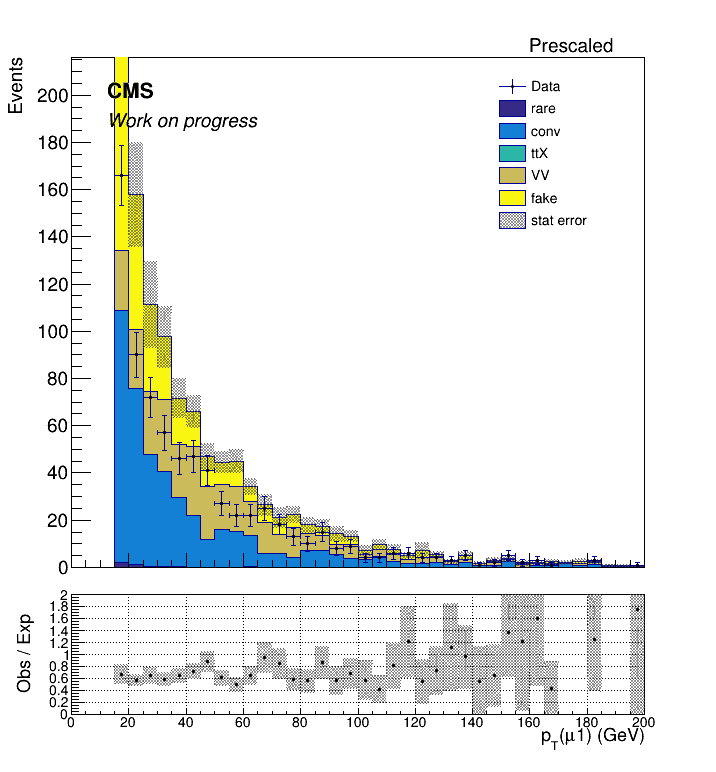

In [9]:
# plot
cvs_params = {
    "logy": False,
    "grid": False
}
info_params = {
    "info": "Prescaled",
    "cms_text": "CMS",
    "extra_text": "Work on progress"
}
hist_params = {
    "x_title": "p_{T}(#mu1) (GeV)",
    "x_range": [0., 200.],
    "y_title": "Events",
    "rebin": 5,
    "ratio_range": [0., 2.0]
}

h_mc = dict()
for mc in mc_list:
    h_mc[mc] = hists[mc].Clone("mc_clone")
    h_mc[mc].SetDirectory(0)

plotter = ObsAndExp(cvs_params, hist_params, info_params)
plotter.get_hists(h_data, h_mc)
plotter.combine()
plotter.draw()

